2019.06.07 

I Added 'Psuedo Labeling' Function

In [16]:
import os, gc, time, datetime, random
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('max_columns', 9999)
pd.set_option('max_rows', 9999)

start = time.time()

os.listdir('../input')

['test.csv', 'train.csv', 'sample_submission.csv']

In [17]:
def load_data(nrows=None):
    train = pd.read_csv('../input/train.csv', nrows=nrows)
    test = pd.read_csv('../input/test.csv')

    print('Train Shape: {}'.format(train.shape))
    print('Test Shape: {}'.format(test.shape))
    
    return train, test

In [18]:
def trainer(train, test, cv, _scaler=True, pca=False, variance=False, model=None, plot=True):
    _train, _test = train.copy(), test.copy()
    _test['target'] = -1
    cols = [col for col in _train.columns if not col in ['id', 'target', 'wheezy-copper-turtle-magic']]
    
    # Setting
    preds = np.zeros(len(_test))
    oof = np.zeros(len(_train))
    
    for i in tqdm(range(512)):
        train_2 = _train[_train['wheezy-copper-turtle-magic'] == i]
        test_2 = _test[_test['wheezy-copper-turtle-magic'] == i]
        len_train = len(train_2)
        Y = train_2['target'].reset_index(drop=True).values
        train_index = train_2.index
        test_index = test_2.index      
        
        # Merge Train and Test Data
        merged_data = pd.concat([train_2, test_2], axis=0).reset_index(drop=True)[cols].values
        
        # Dimensionality Reduction
        if pca:
            clf = PCA(svd_solver='full',n_components='mle')
            _X = clf.fit_transform(merged_data)
        elif variance:
            clf = VarianceThreshold(threshold=1.5)
            _X = clf.fit_transform(merged_data)
        else:
            _X = merged_data
            
        # Scaler - Standardization
        if _scaler:
            _scaler = StandardScaler()
            _X = _scaler.fit_transform(_X)
        
        # Divide Train, Test data
        X = _X[:len_train]
        test_2 = _X[len_train:]
        del merged_data, _X
        gc.collect()
        
        # Model
        for i, (trn_index, val_index) in enumerate(cv.split(X, Y)):
            X_trn, X_val = X[trn_index], X[val_index]
            Y_trn, Y_val = Y[trn_index], Y[val_index]
                
            model.fit(X_trn, Y_trn)
            oof[train_index[val_index]] += model.predict_proba(X_val)[:,1]
            preds[test_index] += model.predict_proba(test_2)[:,1] / cv.n_splits
    
    oof_df = pd.DataFrame({
        'target': _train['target'],
        'oof': oof
    })
    
    oof_df_0 = oof_df[oof_df['target'] == 0]
    oof_df_1 = oof_df[oof_df['target'] == 1]
    
    # Plotting Histogram
    if plot:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        sns.distplot(np.array(preds), kde=False, bins=25, ax=axes[0])
        axes[0].set_title('Prediction Histogram')

        sns.kdeplot(oof_df_0['oof'].values, shade=True, color="b", label='0', ax=axes[1])
        sns.kdeplot(oof_df_1['oof'].values, shade=True, color="r", label='1', ax=axes[1])
        axes[1].set_title('OOF KdePlots')
        plt.show()
    
        # Scoring
        auc = roc_auc_score(_train['target'], oof)
        print('AUC: {:.3f}'.format(auc))
    
    return np.array(preds), oof

In [19]:
def PsuedoLabeling(train, test, _min=0.01, _max=0.99):
    _train = train.copy()
    _test = test.copy()
    # First Model
#     print('Before Psuedo Labeling Train Data Shape: {}'.format(train.shape))
    qda_params = {
        'reg_param': random.uniform(0.01, 0.60)
    }
    cv = StratifiedKFold(n_splits=15)
    model = QuadraticDiscriminantAnalysis(**qda_params)
    preds, oof = trainer(_train, _test, cv, _scaler=False, variance=True, model=model, plot=False)
    
    _test['target'] = preds
    test_0 = _test[_test['target'] < _min]
    test_0['target'] = 0
    test_1 = _test[_test['target'] > _max]
    test_1['target'] = 1
    
    train = pd.concat([train, test_0], axis=0).reset_index(drop=True)
    train = pd.concat([train, test_1], axis=0).reset_index(drop=True)
    
    print('After Psuedo Labeling Train Data Shape: {}'.format(train.shape))
    
    return train

Train Shape: (262144, 258)
Test Shape: (131073, 257)


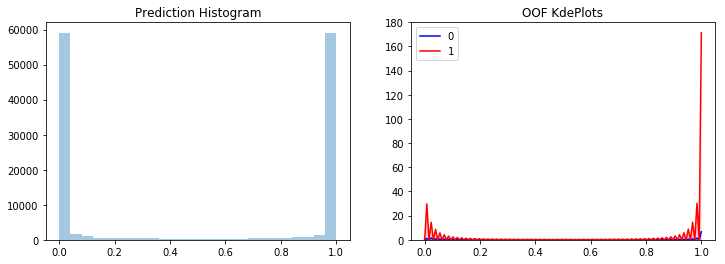

AUC: 0.966
After Psuedo Labeling Train Data Shape: (374753, 258)


In [20]:
# Loading Train/Test Data
train, test = load_data()
train = PsuedoLabeling(train, test, _min=0.01, _max=0.99)

In [ ]:
# Setting Parameter
lr_params = {
    'solver': 'lbfgs',
    'penalty': 'l2',
    'C': 0.1
}

svc_params = {
    'probability': True,
    'kernel': 'poly',
    'degree': 4,
    'gamma': 'auto',
}

nusvc_params = {
    'probability': True,
    'kernel': 'poly',
    'degree': 4,
    'gamma': 'auto',
    'coef0': 0.053,
    'nu': 0.59
}

knn_params = {
    'n_neighbors': 17,
    'p': 2.9
}

mlp_params = {
    'activation': 'relu',
    'solver': 'lbfgs',
    'tol': 1e-6,
    'hidden_layer_sizes': (250, )
}

qda_params = {
    'reg_param': 0.111
}

In [ ]:
estimators = [
    ('lr', LogisticRegression(**lr_params)),
    ('svc', SVC(**svc_params)),
    ('nusvc', NuSVC(**nusvc_params)),
    ('knn', KNeighborsClassifier(**knn_params)),
    ('mlp', MLPClassifier(**mlp_params)),
    ('qda', QuadraticDiscriminantAnalysis(**qda_params))
]

weights = [1, 2, 3, 1, 2, 4]
model = VotingClassifier(estimators, voting='soft', weights=weights)

cv = StratifiedKFold(n_splits=10, random_state=46)

preds, oof = trainer(train, test, cv, model=model, pca=True)

In [ ]:
# submit
submit = pd.read_csv('../input/sample_submission.csv')
submit['target'] = preds
submit.to_csv('submission.csv', index=False)

In [ ]:
end = time.time()
t = datetime.timedelta(seconds=end - start)

print('This Kernel Runnnig Time: {}'.format(str(t)))